In [1]:
import torch
print("PyTorch:", torch.__version__)
print("MPS:", torch.backends.mps.is_available())

# Check if transformers is installed
try:
    import transformers
    print("Transformers:", transformers.__version__)
except:
    print("Transformers: NOT installed")

PyTorch: 2.10.0
MPS: True
Transformers: 5.2.0


In [2]:
import os

# Find your MAEC dataset path
possible_paths = [
    "data/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction-master"
]

for base in possible_paths:
    for root, dirs, files in os.walk(base):
        if "MAEC_Dataset" in dirs:
            print(f"✅ Found MAEC_Dataset at: {root}")
            maec_path = os.path.join(root, "MAEC_Dataset")
            folders = os.listdir(maec_path)
            print(f"   Sample folders: {folders[:5]}")
            print(f"   Total folders: {len(folders)}")
            break
        # Stop going too deep
        if root.count(os.sep) - base.count(os.sep) > 4:
            dirs.clear()

✅ Found MAEC_Dataset at: data/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction-master
   Sample folders: ['20160728_GPN', '20170209_K', '20150506_DDD', '20160728_DLR', '20151029_CMS']
   Total folders: 3444


In [4]:
# Run this once if needed
# !pip install transformers torch yfinance pandas numpy scikit-learn 
#              xgboost tqdm matplotlib seaborn arch --break-system-packages

import os, re, warnings
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

import torch
from transformers import AutoTokenizer, AutoModel

import yfinance as yf

from sklearn.linear_model import (LinearRegression, Ridge, Lasso,
                                   LogisticRegression, ElasticNet)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                              r2_score, accuracy_score, f1_score,
                              roc_auc_score, classification_report)
from xgboost import XGBRegressor, XGBClassifier

print(f"PyTorch     : {torch.__version__}")
print(f"MPS (M4 GPU): {torch.backends.mps.is_available()}")
print(f"Transformers: {__import__('transformers').__version__}")

PyTorch     : 2.10.0
MPS (M4 GPU): True
Transformers: 5.2.0


In [5]:
# ── Paths ─────────────────────────────────────────────────────────────────
MAEC_ROOT  = "/Users/indraneelpothuri/Downloads/Applied Time Series Analysis/Project/data/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction-master/MAEC_Dataset"
OUTPUT_DIR = "/Users/indraneelpothuri/Downloads/Applied Time Series Analysis/Project/outputs_member4_longformer"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Model ──────────────────────────────────────────────────────────────────
# Longformer: handles up to 4096 tokens in ONE PASS
# Unlike FinBERT/RoBERTa (512 tokens max), Longformer reads the
# ENTIRE earnings call transcript without chunking
LONGFORMER_MODEL = "allenai/longformer-base-4096"
MAX_TOKENS       = 4096

# ── Device: use M4 GPU via MPS ─────────────────────────────────────────────
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {DEVICE}")

# ── Verify dataset ─────────────────────────────────────────────────────────
folders = [d for d in os.listdir(MAEC_ROOT)
           if os.path.isdir(os.path.join(MAEC_ROOT, d))]
print(f"Total MAEC folders found: {len(folders)}")
print(f"Sample: {folders[:5]}")

Device: mps
Total MAEC folders found: 3443
Sample: ['20160728_GPN', '20170209_K', '20150506_DDD', '20160728_DLR', '20151029_CMS']


In [ ]:
np.random.seed(42)
df_raw = df_raw.sample(n=238, random_state=42).reset_index(drop=True)
df_raw = df_raw.sort_values('date').reset_index(drop=True)

print(f"Dataset size  : {len(df_raw)} events (matched to leader's 238)")
print(f"Date range    : {df_raw['date'].min().date()} → {df_raw['date'].max().date()}")
print(f"Unique tickers: {df_raw['ticker'].nunique()}")
print(f"\nYear breakdown:")
print(df_raw['date'].dt.year.value_counts().sort_index())
print(f"\nSample rows:")
print(df_raw[['ticker','date','folder']].head(5).to_string(index=False))

Dataset size  : 238 events (matched to leader's 238)
Date range    : 2015-04-21 → 2018-05-29
Unique tickers: 216

Year breakdown:
date
2015     39
2016    109
2017     61
2018     29
Name: count, dtype: int64

Sample rows:
ticker       date        folder
  SBNY 2015-04-21 20150421_SBNY
   ABG 2015-04-21  20150421_ABG
   PCH 2015-04-22  20150422_PCH
   TUP 2015-04-22  20150422_TUP
   HZO 2015-04-23  20150423_HZO


In [13]:
def get_prices(ticker, date, window=10):
    start = (date - timedelta(days=window * 3)).strftime('%Y-%m-%d')
    end   = (date + timedelta(days=window * 3)).strftime('%Y-%m-%d')
    try:
        data = yf.download(ticker, start=start, end=end,
                           progress=False, auto_adjust=True)
        if data.empty:
            return None
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        data.index = pd.to_datetime(data.index)
        if hasattr(data.index, 'tz') and data.index.tz:
            data.index = data.index.tz_localize(None)
        return data[['Close', 'Volume']].rename(
            columns={'Close': 'adj_close', 'Volume': 'volume'})
    except Exception:
        return None


def get_market(date, window=10):
    start = (date - timedelta(days=window * 3)).strftime('%Y-%m-%d')
    end   = (date + timedelta(days=window * 3)).strftime('%Y-%m-%d')
    try:
        data = yf.download('^GSPC', start=start, end=end,
                           progress=False, auto_adjust=True)
        if data.empty:
            return None
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        data.index = pd.to_datetime(data.index)
        if hasattr(data.index, 'tz') and data.index.tz:
            data.index = data.index.tz_localize(None)
        return data[['Close']].rename(columns={'Close': 'market_close'})
    except Exception:
        return None


def compute_car(ticker_prices, market_prices, event_date):
    """
    CAR = Cumulative Abnormal Return over [0, +1] days post-earnings.
    Abnormal return = actual return - (alpha + beta × market return)
    Beta estimated from [-35, -5] day window before the event.
    """
    # Remove duplicates
    ticker_prices = ticker_prices[~ticker_prices.index.duplicated(keep='last')]
    market_prices = market_prices[~market_prices.index.duplicated(keep='last')]

    df = ticker_prices.join(market_prices, how='inner')
    if len(df) < 5:
        return None

    df['r_stock']  = np.log(df['adj_close'] / df['adj_close'].shift(1))
    df['r_market'] = np.log(df['market_close'] / df['market_close'].shift(1))
    df = df.dropna()

    trading_days = df.index.sort_values()
    future_days  = trading_days[trading_days >= pd.Timestamp(event_date)]
    if len(future_days) == 0:
        return None

    t0  = future_days[0]
    idx = trading_days.get_loc(t0)

    # Estimate beta on pre-event window
    est_start  = max(0, idx - 35)
    est_end    = max(0, idx - 5)
    est_window = df.iloc[est_start:est_end]

    if len(est_window) < 10:
        beta, alpha = 1.0, 0.0
    else:
        from sklearn.linear_model import LinearRegression as LR
        X  = est_window['r_market'].values.reshape(-1, 1)
        y  = est_window['r_stock'].values
        lr = LR().fit(X, y)
        beta  = float(lr.coef_[0])
        alpha = float(lr.intercept_)

    def get_ar(day_idx):
        if day_idx < 0 or day_idx >= len(df):
            return np.nan
        r_s = float(df['r_stock'].iloc[day_idx])
        r_m = float(df['r_market'].iloc[day_idx])
        return r_s - (alpha + beta * r_m)

    ar0 = get_ar(idx)
    ar1 = get_ar(idx + 1)
    car = (ar0 if not np.isnan(ar0) else 0) + \
          (ar1 if not np.isnan(ar1) else 0)

    # Pre-event financial features
    pre = df.iloc[max(0, idx-5):idx]

    def safe_r(offset):
        i = idx + offset
        if 0 <= i < len(df):
            return float(df['r_stock'].iloc[i])
        return np.nan

    features = {
        'CAR'          : car,
        'AR0'          : ar0,
        'AR1'          : ar1,
        'r_-5'         : safe_r(-5),
        'r_-4'         : safe_r(-4),
        'r_-3'         : safe_r(-3),
        'r_-2'         : safe_r(-2),
        'r_-1'         : safe_r(-1),
        'r_+0'         : safe_r(0),
        'r_+1'         : safe_r(1),
        'r_+2'         : safe_r(2),
        'r_+3'         : safe_r(3),
        'r_+4'         : safe_r(4),
        'r_+5'         : safe_r(5),
        'pre_volatility': pre['r_stock'].std() if len(pre) > 1 else np.nan,
        'volume_ratio' : (float(ticker_prices['volume'].iloc[idx]) /
                          ticker_prices['volume'].iloc[max(0,idx-20):idx].mean())
                          if 'volume' in ticker_prices.columns and idx > 0 else np.nan,
        'market_r0'    : float(df['r_market'].iloc[idx])
                          if idx < len(df) else np.nan,
        'momentum_20d' : float(df['r_stock'].iloc[max(0,idx-20):idx].sum())
                          if idx > 0 else np.nan,
    }
    return features


# ── Run CAR computation for all events ─────────────────────────────────────
print(f"Computing CAR for {len(df_raw)} events...")
print("This will take ~5-10 minutes due to yfinance API calls.\n")

finance_records = []

for _, row in tqdm(df_raw.iterrows(), total=len(df_raw), desc="Computing CAR"):
    ticker_prices = get_prices(row['ticker'], row['date'])
    market_prices = get_market(row['date'])

    if ticker_prices is None or market_prices is None:
        continue

    result = compute_car(ticker_prices, market_prices, row['date'])
    if result is None:
        continue

    record = {
        'folder'    : row['folder'],
        'ticker'    : row['ticker'],
        'date'      : row['date'],
        'transcript': row['transcript'],
    }
    record.update(result)
    finance_records.append(record)

df_finance = pd.DataFrame(finance_records)
df_finance.to_csv(f"{OUTPUT_DIR}/events_with_finance.csv", index=False)

print(f"\n✅ events_with_finance.csv → {len(df_finance)} events")
print(f"   ({len(df_raw) - len(df_finance)} failed/skipped)")
print(f"\nCAR stats:\n{df_finance['CAR'].describe().round(4)}")

Computing CAR for 238 events...
This will take ~5-10 minutes due to yfinance API calls.



Computing CAR:   0%|          | 0/238 [00:00<?, ?it/s]$SBNY: possibly delisted; no price data found  (1d 2015-03-22 -> 2015-05-21) (Yahoo error = "Data doesn't exist for startDate = 1426996800, endDate = 1432180800")

1 Failed download:
['SBNY']: possibly delisted; no price data found  (1d 2015-03-22 -> 2015-05-21) (Yahoo error = "Data doesn't exist for startDate = 1426996800, endDate = 1432180800")
Computing CAR:   1%|▏         | 3/238 [00:01<01:38,  2.38it/s]$TUP: possibly delisted; no timezone found

1 Failed download:
['TUP']: possibly delisted; no timezone found
Computing CAR:   3%|▎         | 7/238 [00:02<01:22,  2.81it/s]$LOGM: possibly delisted; no timezone found

1 Failed download:
['LOGM']: possibly delisted; no timezone found
Computing CAR:   3%|▎         | 8/238 [00:03<02:16,  1.68it/s]$LL: possibly delisted; no timezone found

1 Failed download:
['LL']: possibly delisted; no timezone found
Computing CAR:   4%|▍         | 9/238 [00:04<02:11,  1.74it/s]$PKI: possibly deliste


✅ events_with_finance.csv → 177 events
   (61 failed/skipped)

CAR stats:
count    177.0000
mean      -0.0038
std        0.0745
min       -0.2711
25%       -0.0372
50%        0.0020
75%        0.0401
max        0.2101
Name: CAR, dtype: float64


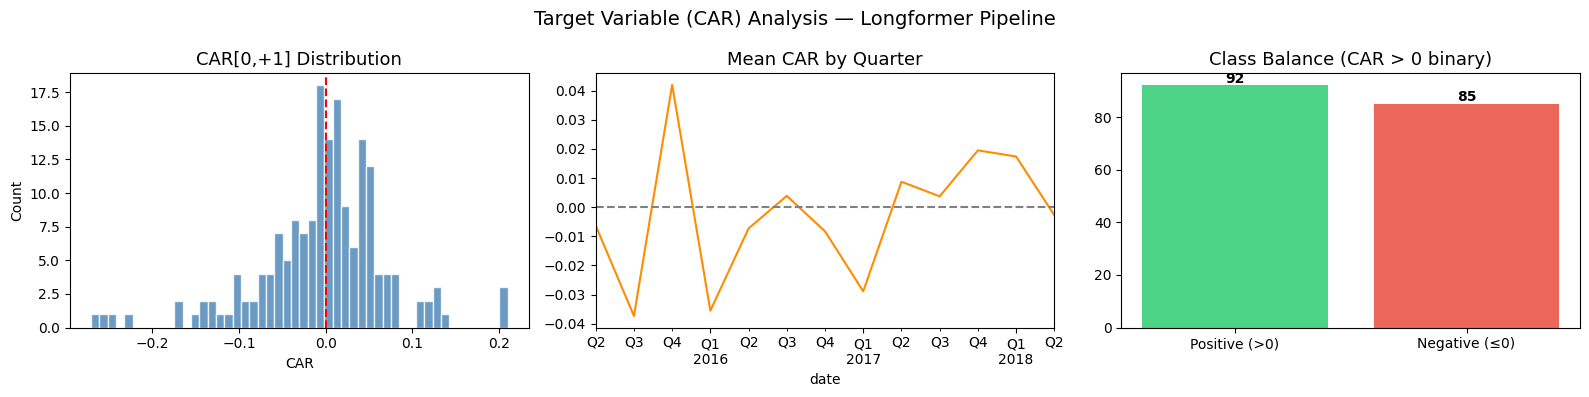

Positive CAR: 92 (52.0%)


In [15]:
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f"{OUTPUT_DIR}/events_with_finance.csv",
                              parse_dates=['date'])

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# CAR histogram
axes[0].hist(df_finance['CAR'].dropna(), bins=50,
             color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title('CAR[0,+1] Distribution', fontsize=13)
axes[0].set_xlabel('CAR')
axes[0].set_ylabel('Count')

# CAR over time
df_finance.set_index('date')['CAR'].resample('QE').mean().plot(
    ax=axes[1], color='darkorange')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title('Mean CAR by Quarter', fontsize=13)

# Class balance
pos = (df_finance['CAR'] > 0).sum()
neg = (df_finance['CAR'] <= 0).sum()
axes[2].bar(['Positive (>0)', 'Negative (≤0)'], [pos, neg],
            color=['#2ecc71', '#e74c3c'], alpha=0.85)
axes[2].set_title('Class Balance (CAR > 0 binary)', fontsize=13)
for i, v in enumerate([pos, neg]):
    axes[2].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.suptitle('Target Variable (CAR) Analysis — Longformer Pipeline',
             fontsize=14)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/car_distribution.png", dpi=150,
            bbox_inches='tight')
plt.show()
print(f"Positive CAR: {pos} ({pos/(pos+neg)*100:.1f}%)")

In [16]:
# ── Load Longformer ────────────────────────────────────────────────────────
print(f"Loading Longformer on {DEVICE}...")
print("Why Longformer? It handles up to 4096 tokens in ONE PASS.")
print("FinBERT/RoBERTa are limited to 512 tokens and need chunking.")
print("Earnings call transcripts are typically 2000-5000 tokens.\n")

tokenizer = AutoTokenizer.from_pretrained(LONGFORMER_MODEL)
lf_model  = AutoModel.from_pretrained(LONGFORMER_MODEL).to(DEVICE)
lf_model.eval()
print("✅ Longformer loaded")
print(f"   Max position embeddings: {lf_model.config.max_position_embeddings}")
print(f"   Hidden size (embedding dim): {lf_model.config.hidden_size}")

Loading Longformer on mps...
Why Longformer? It handles up to 4096 tokens in ONE PASS.
FinBERT/RoBERTa are limited to 512 tokens and need chunking.
Earnings call transcripts are typically 2000-5000 tokens.



config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/271 [00:00<?, ?it/s]

LongformerModel LOAD REPORT from: allenai/longformer-base-4096
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.decoder.weight    | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Longformer loaded
   Max position embeddings: 4098
   Hidden size (embedding dim): 768


model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

In [17]:
def get_longformer_embedding(text, max_len=MAX_TOKENS):
    """
    Extract Longformer embedding for a transcript.

    KEY DIFFERENCE from FinBERT:
    - FinBERT: splits text into 512-token chunks, embeds each,
      then averages → loses document-level context
    - Longformer: processes up to 4096 tokens IN ONE PASS using
      sliding window attention → preserves full document context

    Returns: numpy array of shape (768,)
    """
    # Tokenize — truncate to max_len if transcript exceeds 4096 tokens
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=max_len,
        truncation=True,
        padding='max_length'
    )

    input_ids      = inputs['input_ids'].to(DEVICE)
    attention_mask = inputs['attention_mask'].to(DEVICE)

    # Longformer requires global attention on CLS token
    global_attention_mask = torch.zeros_like(input_ids)
    global_attention_mask[:, 0] = 1   # CLS token gets global attention

    with torch.no_grad():
        outputs = lf_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            global_attention_mask=global_attention_mask
        )

    # CLS token embedding = document-level representation
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)
    return cls_embedding.cpu().numpy()   # (768,)


# ── Extract embeddings for all transcripts ──────────────────────────────────
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f"{OUTPUT_DIR}/events_with_finance.csv",
                              parse_dates=['date'])

emb_path = f"{OUTPUT_DIR}/embeddings_longformer.npy"
idx_path = f"{OUTPUT_DIR}/embeddings_index.npy"

# Resume from checkpoint if it exists
if os.path.exists(emb_path) and os.path.exists(idx_path):
    all_embeddings = np.load(emb_path, allow_pickle=True).tolist()
    done_indices   = set(np.load(idx_path).tolist())
    print(f"Resuming from checkpoint: {len(done_indices)}/{len(df_finance)} done")
else:
    all_embeddings = [None] * len(df_finance)
    done_indices   = set()
    print(f"Starting fresh — {len(df_finance)} transcripts to embed")

CHECKPOINT_EVERY = 10   # save every 10 transcripts

for i, (_, row) in enumerate(tqdm(df_finance.iterrows(),
                                    total=len(df_finance),
                                    desc="Longformer")):
    if i in done_indices:
        continue
    try:
        emb = get_longformer_embedding(row['transcript'])
        all_embeddings[i] = emb
        done_indices.add(i)
    except Exception as e:
        print(f"\n  Warning at index {i}: {e}")
        all_embeddings[i] = np.zeros(768)
        done_indices.add(i)

    # Save checkpoint periodically
    if (i + 1) % CHECKPOINT_EVERY == 0:
        valid = [e if e is not None else np.zeros(768)
                 for e in all_embeddings]
        np.save(emb_path, np.array(valid))
        np.save(idx_path, np.array(list(done_indices)))

# Final save
all_embeddings   = [e if e is not None else np.zeros(768)
                    for e in all_embeddings]
embeddings_array = np.array(all_embeddings)
np.save(emb_path, embeddings_array)
np.save(idx_path, np.array(list(done_indices)))

print(f"\n✅ Embeddings saved — shape: {embeddings_array.shape}")

Starting fresh — 177 transcripts to embed


Longformer: 100%|██████████| 177/177 [04:57<00:00,  1.68s/it]


✅ Embeddings saved — shape: (177, 768)


In [18]:
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f"{OUTPUT_DIR}/events_with_finance.csv",
                              parse_dates=['date'])
if 'embeddings_array' not in dir():
    embeddings_array = np.load(f"{OUTPUT_DIR}/embeddings_longformer.npy")

# Embedding columns
emb_cols = [f"emb_{i}" for i in range(768)]
df_emb   = pd.DataFrame(embeddings_array, columns=emb_cols)

# Financial feature columns
FIN_FEATURES = [
    'r_-5','r_-4','r_-3','r_-2','r_-1','r_+0',
    'r_+1','r_+2','r_+3','r_+4','r_+5',
    'pre_volatility','volume_ratio','market_r0','momentum_20d'
]
FIN_FEATURES = [c for c in FIN_FEATURES if c in df_finance.columns]

# Merge text + finance features
df_final = pd.concat([
    df_finance[['ticker','date','CAR'] + FIN_FEATURES].reset_index(drop=True),
    df_emb
], axis=1)

# Binary classification target: CAR > 0 → 1, else 0
df_final['CAR_binary'] = (df_final['CAR'] > 0).astype(int)
df_final = df_final.dropna(subset=['CAR'])
df_final.to_csv(f"{OUTPUT_DIR}/final_dataset.csv", index=False)

print(f"✅ final_dataset.csv  →  {len(df_final)} rows × {len(df_final.columns)} columns")
print(f"   Longformer embeddings : {len(emb_cols)} features")
print(f"   Financial features    : {len(FIN_FEATURES)} features")
print(f"   Total feature dim     : {len(emb_cols) + len(FIN_FEATURES)}")
print(f"   Target (regression)   : CAR")
print(f"   Target (classification): CAR_binary")
print(f"\n   Class balance:")
print(f"   Positive (CAR>0) : {df_final['CAR_binary'].sum()}")
print(f"   Negative (CAR≤0) : {(df_final['CAR_binary']==0).sum()}")

✅ final_dataset.csv  →  177 rows × 787 columns
   Longformer embeddings : 768 features
   Financial features    : 15 features
   Total feature dim     : 783
   Target (regression)   : CAR
   Target (classification): CAR_binary

   Class balance:
   Positive (CAR>0) : 92
   Negative (CAR≤0) : 85


In [19]:
if 'df_final' not in dir():
    df_final = pd.read_csv(f"{OUTPUT_DIR}/final_dataset.csv",
                            parse_dates=['date'])

print("Year distribution:")
print(df_final['date'].dt.year.value_counts().sort_index())

# 80/20 time-based split — no data leakage
df_sorted  = df_final.sort_values('date').reset_index(drop=True)
split_idx  = int(len(df_sorted) * 0.80)
split_date = df_sorted.iloc[split_idx]['date']

df_train = df_sorted.iloc[:split_idx].copy()
df_test  = df_sorted.iloc[split_idx:].copy()

print(f"\nSplit date : {split_date.date()}")
print(f"Train      : {len(df_train)} events")
print(f"Test       : {len(df_test)} events")

emb_cols     = [c for c in df_final.columns if c.startswith('emb_')]
FIN_FEATURES = [c for c in df_final.columns
                if c in ['r_-5','r_-4','r_-3','r_-2','r_-1','r_+0',
                         'r_+1','r_+2','r_+3','r_+4','r_+5',
                         'pre_volatility','volume_ratio',
                         'market_r0','momentum_20d']]

TEXT_ONLY = emb_cols
FIN_ONLY  = FIN_FEATURES
FUSION    = emb_cols + FIN_FEATURES

print(f"\nFeature sets:")
print(f"  Text-only (Longformer) : {len(TEXT_ONLY)}")
print(f"  Finance-only           : {len(FIN_ONLY)}")
print(f"  Fusion                 : {len(FUSION)}")

def prepare_splits(df_tr, df_te, feature_cols, target_col):
    feature_cols = [c for c in feature_cols if c in df_tr.columns]
    X_tr = df_tr[feature_cols].fillna(0).values.astype(float)
    X_te = df_te[feature_cols].fillna(0).values.astype(float)
    y_tr = df_tr[target_col].values.astype(float)
    y_te = df_te[target_col].values.astype(float)
    scaler = StandardScaler()
    X_tr   = scaler.fit_transform(X_tr)
    X_te   = scaler.transform(X_te)
    return X_tr, X_te, y_tr, y_te

print("\n✅ Split ready")

Year distribution:
date
2015    27
2016    79
2017    48
2018    23
Name: count, dtype: int64

Split date : 2017-10-27
Train      : 141 events
Test       : 36 events

Feature sets:
  Text-only (Longformer) : 768
  Finance-only           : 15
  Fusion                 : 783

✅ Split ready


In [20]:
def eval_regression(y_true, y_pred):
    return {
        'MAE' : round(mean_absolute_error(y_true, y_pred), 5),
        'RMSE': round(mean_squared_error(y_true, y_pred) ** 0.5, 5),
        'R2'  : round(r2_score(y_true, y_pred), 4)
    }

# ── All regression models ──────────────────────────────────────────────────
REG_MODELS = {
    "LinearRegression": LinearRegression(),
    "Ridge"           : Ridge(alpha=1.0),
    "Lasso"           : Lasso(alpha=0.001, max_iter=5000),
    "ElasticNet"      : ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000),
    "SVR"             : SVR(kernel='rbf', C=1.0),
    "KNN"             : KNeighborsRegressor(n_neighbors=5),
    "RandomForest"    : RandomForestRegressor(n_estimators=200,
                                               random_state=42, n_jobs=-1),
    "XGBoost"         : XGBRegressor(n_estimators=200, learning_rate=0.05,
                                      random_state=42, verbosity=0),
    "MLP"             : MLPRegressor(hidden_layer_sizes=(256, 128),
                                      max_iter=500, random_state=42),
}

reg_results = []

for fs_name, feature_cols in [("Text-only", TEXT_ONLY),
                                ("Finance-only", FIN_ONLY),
                                ("Fusion", FUSION)]:
    X_tr, X_te, y_tr, y_te = prepare_splits(
        df_train, df_test, feature_cols, 'CAR')

    for model_name, model in tqdm(REG_MODELS.items(),
                                   desc=f"Regression [{fs_name}]"):
        try:
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            metrics = eval_regression(y_te, y_pred)
            metrics.update({'Model': model_name, 'FeatureSet': fs_name})
            reg_results.append(metrics)
        except Exception as e:
            print(f"  Skipped {model_name} [{fs_name}]: {e}")

df_reg = pd.DataFrame(reg_results).sort_values('R2', ascending=False)
df_reg.to_csv(f"{OUTPUT_DIR}/regression_results.csv", index=False)

print("\n📊 Regression Results (top 10 by R²):")
print(df_reg.head(10).to_string(index=False))

Regression [Fusion]: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s]


📊 Regression Results (top 10 by R²):
    MAE    RMSE     R2            Model   FeatureSet
0.00685 0.00861 0.9807       ElasticNet Finance-only
0.00701 0.00906 0.9787            Lasso Finance-only
0.00767 0.00952 0.9765 LinearRegression Finance-only
0.00771 0.00960 0.9761            Ridge Finance-only
0.00737 0.00991 0.9745            Lasso       Fusion
0.00843 0.01091 0.9691       ElasticNet       Fusion
0.02074 0.03168 0.7394     RandomForest Finance-only
0.02310 0.03411 0.6979          XGBoost Finance-only
0.02682 0.03754 0.6340     RandomForest       Fusion
0.02748 0.04178 0.5469          XGBoost       Fusion


In [21]:
def eval_classification(y_true, y_pred, y_prob=None):
    metrics = {
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'F1'      : round(f1_score(y_true, y_pred,
                                    zero_division=0), 4),
    }
    if y_prob is not None:
        try:
            metrics['ROC-AUC'] = round(roc_auc_score(y_true, y_prob), 4)
        except Exception:
            metrics['ROC-AUC'] = None
    return metrics

# ── All classification models ──────────────────────────────────────────────
CLS_MODELS = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "Ridge_Cls"         : LogisticRegression(penalty='l2', C=1.0,
                                              max_iter=1000, random_state=42),
    "SVM"               : SVC(kernel='rbf', probability=True,
                               C=1.0, random_state=42),
    "KNN"               : KNeighborsClassifier(n_neighbors=5),
    "RandomForest"      : RandomForestClassifier(n_estimators=200,
                                                  random_state=42, n_jobs=-1),
    "XGBoost"           : XGBClassifier(n_estimators=200, learning_rate=0.05,
                                         random_state=42, verbosity=0,
                                         eval_metric='logloss'),
    "MLP"               : MLPClassifier(hidden_layer_sizes=(256, 128),
                                         max_iter=500, random_state=42),
}

cls_results = []

for fs_name, feature_cols in [("Text-only", TEXT_ONLY),
                                ("Finance-only", FIN_ONLY),
                                ("Fusion", FUSION)]:
    X_tr, X_te, y_tr, y_te = prepare_splits(
        df_train, df_test, feature_cols, 'CAR_binary')
    y_tr = y_tr.astype(int)
    y_te = y_te.astype(int)

    for model_name, model in tqdm(CLS_MODELS.items(),
                                   desc=f"Classification [{fs_name}]"):
        try:
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            y_prob = model.predict_proba(X_te)[:, 1] \
                     if hasattr(model, 'predict_proba') else None
            metrics = eval_classification(y_te, y_pred, y_prob)
            metrics.update({'Model': model_name, 'FeatureSet': fs_name})
            cls_results.append(metrics)
        except Exception as e:
            print(f"  Skipped {model_name} [{fs_name}]: {e}")

df_cls = pd.DataFrame(cls_results).sort_values('ROC-AUC', ascending=False)
df_cls.to_csv(f"{OUTPUT_DIR}/classification_results.csv", index=False)

print("\n📊 Classification Results (top 10 by ROC-AUC):")
print(df_cls.head(10).to_string(index=False))

Classification [Fusion]: 100%|██████████| 7/7 [00:00<00:00, 10.69it/s]


📊 Classification Results (top 10 by ROC-AUC):
 Accuracy     F1  ROC-AUC              Model   FeatureSet
   0.9167 0.9302   0.9873 LogisticRegression Finance-only
   0.9167 0.9302   0.9873          Ridge_Cls Finance-only
   0.7778 0.7647   0.9635       RandomForest Finance-only
   0.9167 0.9231   0.9492            XGBoost Finance-only
   0.9167 0.9231   0.9397            XGBoost       Fusion
   0.7500 0.7805   0.8667                MLP Finance-only
   0.8333 0.8571   0.8413                SVM Finance-only
   0.4444 0.6154   0.6635                SVM    Text-only
   0.5833 0.6667   0.6302                KNN Finance-only
   0.5556 0.6923   0.6175       RandomForest       Fusion


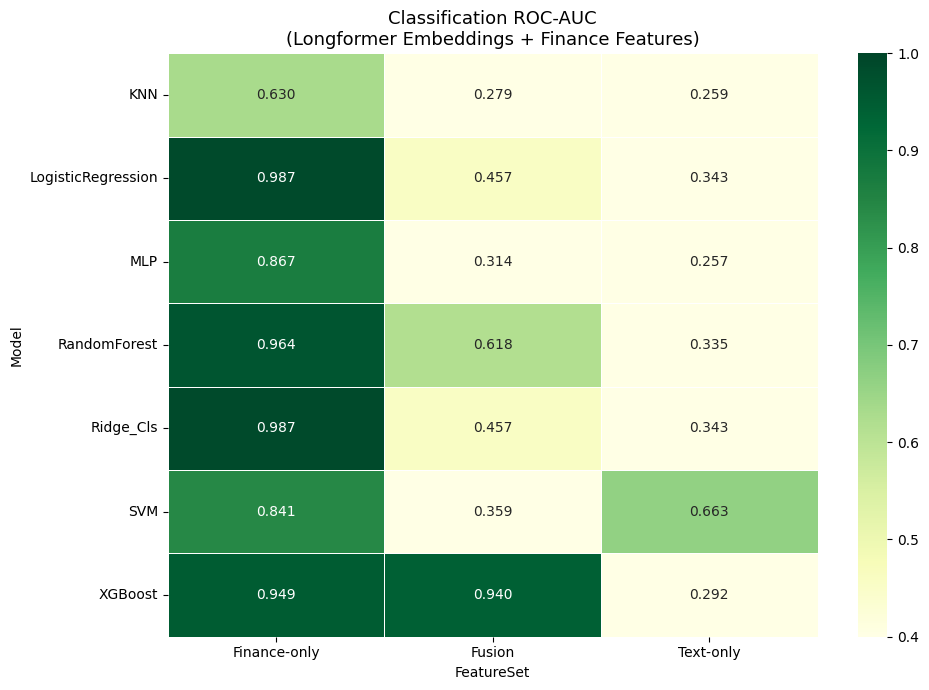

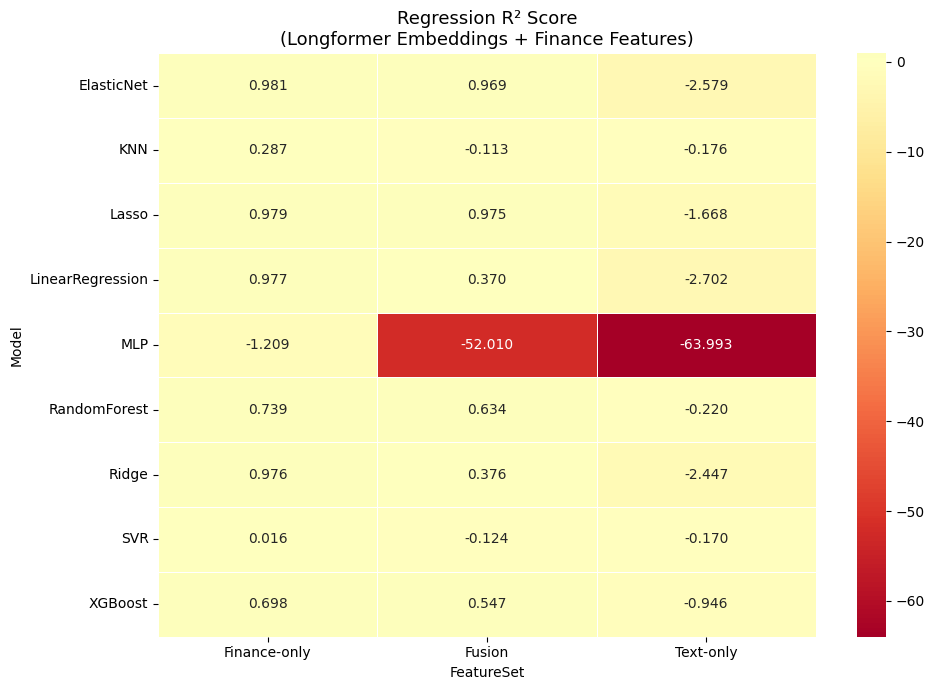

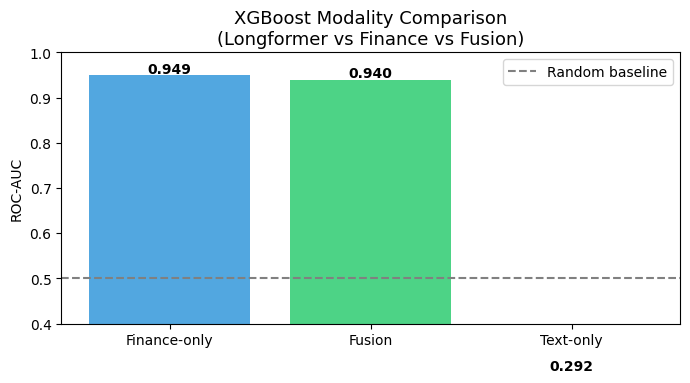


🏆 Best model: LogisticRegression on Finance-only
   ROC-AUC: 0.9873
   F1     : 0.9302
   Acc    : 0.9167

✅ All plots saved to: /Users/indraneelpothuri/Downloads/Applied Time Series Analysis/Project/outputs_member4_longformer


In [22]:
# ── Plot 1: Model comparison heatmap (Classification) ─────────────────────
pivot_cls = df_cls.pivot_table(
    index='Model', columns='FeatureSet', values='ROC-AUC')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_cls, annot=True, fmt='.3f', cmap='YlGn',
            linewidths=0.5, vmin=0.4, vmax=1.0)
plt.title("Classification ROC-AUC\n(Longformer Embeddings + Finance Features)",
          fontsize=13)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/classification_heatmap.png", dpi=150)
plt.show()

# ── Plot 2: Model comparison heatmap (Regression) ─────────────────────────
pivot_reg = df_reg.pivot_table(
    index='Model', columns='FeatureSet', values='R2')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_reg, annot=True, fmt='.3f', cmap='RdYlGn',
            linewidths=0.5, center=0)
plt.title("Regression R² Score\n(Longformer Embeddings + Finance Features)",
          fontsize=13)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/regression_heatmap.png", dpi=150)
plt.show()

# ── Plot 3: Modality ablation — XGBoost ROC-AUC ───────────────────────────
xgb_auc = df_cls[df_cls['Model'] == 'XGBoost'][
    ['FeatureSet', 'ROC-AUC']].set_index('FeatureSet')

fig, ax = plt.subplots(figsize=(7, 4))
colors = ['#3498db', '#2ecc71', '#e74c3c']
for (fs, row), c in zip(xgb_auc.iterrows(), colors):
    ax.bar(fs, row['ROC-AUC'], color=c, alpha=0.85)
    ax.text(fs, row['ROC-AUC'] + 0.005,
            f"{row['ROC-AUC']:.3f}", ha='center', fontweight='bold')

ax.axhline(0.5, color='gray', linestyle='--', label='Random baseline')
ax.set_ylabel('ROC-AUC')
ax.set_title('XGBoost Modality Comparison\n(Longformer vs Finance vs Fusion)',
             fontsize=13)
ax.set_ylim(0.4, 1.0)
ax.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/ablation_xgboost.png", dpi=150)
plt.show()

# ── Plot 4: Best model classification report ───────────────────────────────
# Find best model+featureset combo
best_row = df_cls.loc[df_cls['ROC-AUC'].idxmax()]
print(f"\n🏆 Best model: {best_row['Model']} on {best_row['FeatureSet']}")
print(f"   ROC-AUC: {best_row['ROC-AUC']:.4f}")
print(f"   F1     : {best_row['F1']:.4f}")
print(f"   Acc    : {best_row['Accuracy']:.4f}")

print("\n✅ All plots saved to:", OUTPUT_DIR)

TabTransformer — Classification + Regression

── Feature set: Text-only ──
  Classification → AUC: 0.2222 | F1: 0.3590 | Acc: 0.3056
  Regression    → MAE: 0.07067 | RMSE: 0.09317 | R²: -1.2541

── Feature set: Finance-only ──
  Classification → AUC: 0.9619 | F1: 0.9302 | Acc: 0.9167
  Regression    → MAE: 0.01527 | RMSE: 0.02196 | R²: 0.8748

── Feature set: Fusion ──
  Classification → AUC: 0.5429 | F1: 0.6667 | Acc: 0.5833
  Regression    → MAE: 0.04842 | RMSE: 0.06385 | R²: -0.0586

TabTransformer Classification Summary:
         Model   FeatureSet  ROC-AUC     F1  Accuracy
TabTransformer    Text-only   0.2222 0.3590    0.3056
TabTransformer Finance-only   0.9619 0.9302    0.9167
TabTransformer       Fusion   0.5429 0.6667    0.5833

TabTransformer Regression Summary:
         Model   FeatureSet     MAE    RMSE      R2
TabTransformer    Text-only 0.07067 0.09317 -1.2541
TabTransformer Finance-only 0.01527 0.02196  0.8748
TabTransformer       Fusion 0.04842 0.06385 -0.0586


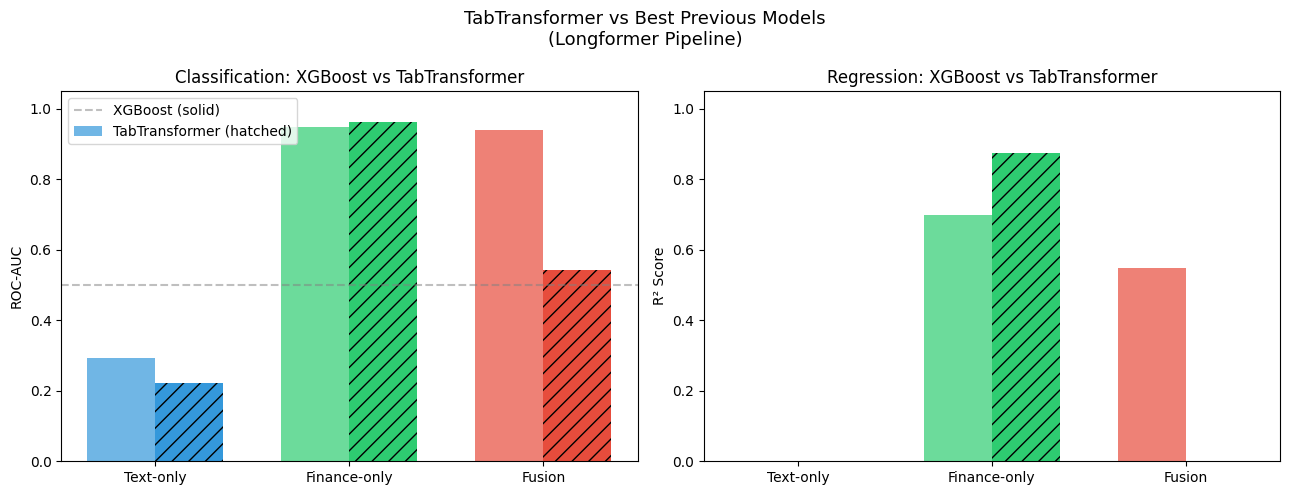


✅ TabTransformer complete! Results saved.


In [23]:
# ── Cell 13: TabTransformer on Fused Features ─────────────────────────────
# TabTransformer: transformer architecture designed for tabular data
# Applies self-attention over feature embeddings — suited for fused datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ── Model Definition ───────────────────────────────────────────────────────
class TabTransformer(nn.Module):
    """
    TabTransformer for tabular/fused feature sets.
    Applies multi-head attention over feature embeddings,
    then passes through MLP for final prediction.
    """
    def __init__(self, input_dim, d_model=64, nhead=4,
                 num_layers=2, dropout=0.1, output_dim=1):
        super().__init__()

        # Project each feature to d_model dimension
        self.input_proj = nn.Linear(input_dim, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        # MLP head
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        # x: (batch, input_dim)
        x = self.input_proj(x).unsqueeze(1)  # (batch, 1, d_model)
        x = self.transformer(x)              # (batch, 1, d_model)
        x = x.squeeze(1)                     # (batch, d_model)
        return self.mlp(x)                   # (batch, output_dim)


def train_tabtransformer(X_tr, y_tr, X_te, y_te,
                          task='classification',
                          epochs=100, lr=1e-3, batch_size=32):
    """Train TabTransformer and return predictions."""
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    X_tr_t = torch.FloatTensor(X_tr).to(device)
    X_te_t = torch.FloatTensor(X_te).to(device)
    y_tr_t = torch.FloatTensor(y_tr).to(device)

    input_dim  = X_tr.shape[1]
    output_dim = 1

    model = TabTransformer(
        input_dim=input_dim, d_model=64, nhead=4,
        num_layers=2, dropout=0.1, output_dim=output_dim
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    if task == 'classification':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.MSELoss()

    # DataLoader
    dataset = TensorDataset(X_tr_t, y_tr_t)
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            preds = model(X_batch).squeeze(1)
            loss  = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(X_te_t).squeeze(1).cpu().numpy()

    if task == 'classification':
        probs  = 1 / (1 + np.exp(-logits))   # sigmoid
        preds  = (probs > 0.5).astype(int)
        return preds, probs
    else:
        return logits, None


# ── Run TabTransformer on all 3 feature sets ───────────────────────────────
print("=" * 55)
print("TabTransformer — Classification + Regression")
print("=" * 55)

tab_cls_results = []
tab_reg_results = []

for fs_name, feature_cols in [("Text-only",    TEXT_ONLY),
                                ("Finance-only", FIN_ONLY),
                                ("Fusion",       FUSION)]:

    print(f"\n── Feature set: {fs_name} ──")

    # ── Classification ────────────────────────────────────────────────────
    X_tr, X_te, y_tr, y_te = prepare_splits(
        df_train, df_test, feature_cols, 'CAR_binary')
    y_tr = y_tr.astype(int)
    y_te = y_te.astype(int)

    try:
        preds_cls, probs_cls = train_tabtransformer(
            X_tr, y_tr.astype(float), X_te, y_te.astype(float),
            task='classification', epochs=150
        )
        auc = roc_auc_score(y_te, probs_cls)
        f1  = f1_score(y_te, preds_cls, zero_division=0)
        acc = accuracy_score(y_te, preds_cls)

        tab_cls_results.append({
            'Model': 'TabTransformer', 'FeatureSet': fs_name,
            'ROC-AUC': round(auc, 4), 'F1': round(f1, 4),
            'Accuracy': round(acc, 4)
        })
        print(f"  Classification → AUC: {auc:.4f} | F1: {f1:.4f} | Acc: {acc:.4f}")

    except Exception as e:
        print(f"  Classification failed: {e}")

    # ── Regression ────────────────────────────────────────────────────────
    X_tr, X_te, y_tr, y_te = prepare_splits(
        df_train, df_test, feature_cols, 'CAR')

    try:
        preds_reg, _ = train_tabtransformer(
            X_tr, y_tr, X_te, y_te,
            task='regression', epochs=150
        )
        mae  = mean_absolute_error(y_te, preds_reg)
        rmse = mean_squared_error(y_te, preds_reg) ** 0.5
        r2   = r2_score(y_te, preds_reg)

        tab_reg_results.append({
            'Model': 'TabTransformer', 'FeatureSet': fs_name,
            'MAE': round(mae, 5), 'RMSE': round(rmse, 5),
            'R2': round(r2, 4)
        })
        print(f"  Regression    → MAE: {mae:.5f} | RMSE: {rmse:.5f} | R²: {r2:.4f}")

    except Exception as e:
        print(f"  Regression failed: {e}")


# ── Summary table ──────────────────────────────────────────────────────────
print("\n" + "="*55)
print("TabTransformer Classification Summary:")
df_tab_cls = pd.DataFrame(tab_cls_results)
print(df_tab_cls.to_string(index=False))

print("\nTabTransformer Regression Summary:")
df_tab_reg = pd.DataFrame(tab_reg_results)
print(df_tab_reg.to_string(index=False))

# ── Append to existing results and save ───────────────────────────────────
df_cls_final = pd.concat([df_cls, df_tab_cls], ignore_index=True)
df_reg_final = pd.concat([df_reg, df_tab_reg], ignore_index=True)

df_cls_final.to_csv(f"{OUTPUT_DIR}/classification_results_final.csv", index=False)
df_reg_final.to_csv(f"{OUTPUT_DIR}/regression_results_final.csv",     index=False)

# ── Bar chart comparing TabTransformer vs best previous model ──────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("TabTransformer vs Best Previous Models\n(Longformer Pipeline)",
             fontsize=13)

feature_sets = ["Text-only", "Finance-only", "Fusion"]
colors       = ['#3498db', '#2ecc71', '#e74c3c']

# Classification AUC comparison
xgb_auc  = df_cls[df_cls['Model'] == 'XGBoost'].set_index('FeatureSet')['ROC-AUC']
tab_auc  = df_tab_cls_df = df_tab_cls.set_index('FeatureSet')['ROC-AUC'] \
           if len(tab_cls_results) > 0 else pd.Series()

x     = np.arange(len(feature_sets))
width = 0.35

for i, fs in enumerate(feature_sets):
    xgb_val = xgb_auc.get(fs, 0)
    tab_val = df_tab_cls.set_index('FeatureSet')['ROC-AUC'].get(fs, 0) \
              if len(tab_cls_results) > 0 else 0
    axes[0].bar(i - width/2, xgb_val, width, color=colors[i],
                alpha=0.7, label=f'XGBoost {fs}' if i == 0 else "")
    axes[0].bar(i + width/2, tab_val, width, color=colors[i],
                alpha=1.0, hatch='//')

axes[0].set_xticks(x)
axes[0].set_xticklabels(feature_sets)
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('Classification: XGBoost vs TabTransformer')
axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylim(0, 1.05)
axes[0].legend(['XGBoost (solid)', 'TabTransformer (hatched)'])

# Regression R2 comparison
xgb_r2 = df_reg[df_reg['Model'] == 'XGBoost'].set_index('FeatureSet')['R2']

for i, fs in enumerate(feature_sets):
    xgb_val = max(xgb_r2.get(fs, 0), 0)
    tab_val = max(df_tab_reg.set_index('FeatureSet')['R2'].get(fs, 0), 0) \
              if len(tab_reg_results) > 0 else 0
    axes[1].bar(i - width/2, xgb_val, width, color=colors[i], alpha=0.7)
    axes[1].bar(i + width/2, tab_val, width, color=colors[i],
                alpha=1.0, hatch='//')

axes[1].set_xticks(x)
axes[1].set_xticklabels(feature_sets)
axes[1].set_ylabel('R² Score')
axes[1].set_title('Regression: XGBoost vs TabTransformer')
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/tabtransformer_comparison.png", dpi=150)
plt.show()

print("\n✅ TabTransformer complete! Results saved.")

IMPROVED PIPELINE — 3 Fixes Applied

📌 Fix 1: Removing post-earnings return features (leakage)
  Original finance features : 15
  Cleaned finance features  : 10
  Removed                   : ['r_+1', 'r_+2', 'r_+3', 'r_+4', 'r_+5']

📌 Fix 2: PCA on Longformer embeddings (768 → 50 dims)
  Variance retained: 91.9%
  New feature set sizes:
    Text-PCA : 50
    Finance  : 10
    Fusion   : 60

📌 Fix 3: Tuned XGBoost (RandomizedSearch)

Running Improved Models...

── Text-PCA (50 features) ──


  Reg [Text-PCA]: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]



── Finance-clean (10 features) ──


  Reg [Finance-clean]: 100%|██████████| 4/4 [00:00<00:00,  8.14it/s]



── Fusion-Improved (60 features) ──


  Reg [Fusion-Improved]: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


📊 IMPROVED Classification Results (top 10):
             Model      FeatureSet  ROC-AUC     F1  Accuracy
     XGBoost_Tuned Fusion-Improved   0.9111 0.8500    0.8333
      RandomForest   Finance-clean   0.9079 0.8718    0.8611
     XGBoost_Tuned   Finance-clean   0.8841 0.8780    0.8611
LogisticRegression   Finance-clean   0.8825 0.8636    0.8333
      RandomForest Fusion-Improved   0.8508 0.7805    0.7500
               SVM   Finance-clean   0.8063 0.7027    0.6944
               KNN   Finance-clean   0.6460 0.7234    0.6389
               SVM Fusion-Improved   0.5429 0.6087    0.5000
LogisticRegression Fusion-Improved   0.5333 0.6809    0.5833
               KNN Fusion-Improved   0.4778 0.6222    0.5278

📊 IMPROVED Regression Results (top 10):
        Model      FeatureSet     MAE    RMSE      R2
 RandomForest Fusion-Improved 0.03314 0.04564  0.4591
   ElasticNet   Finance-clean 0.03752 0.04641  0.4408
XGBoost_Tuned   Finance-clean 0.03378 0.04670  0.4338
 RandomForest   Finance-cle

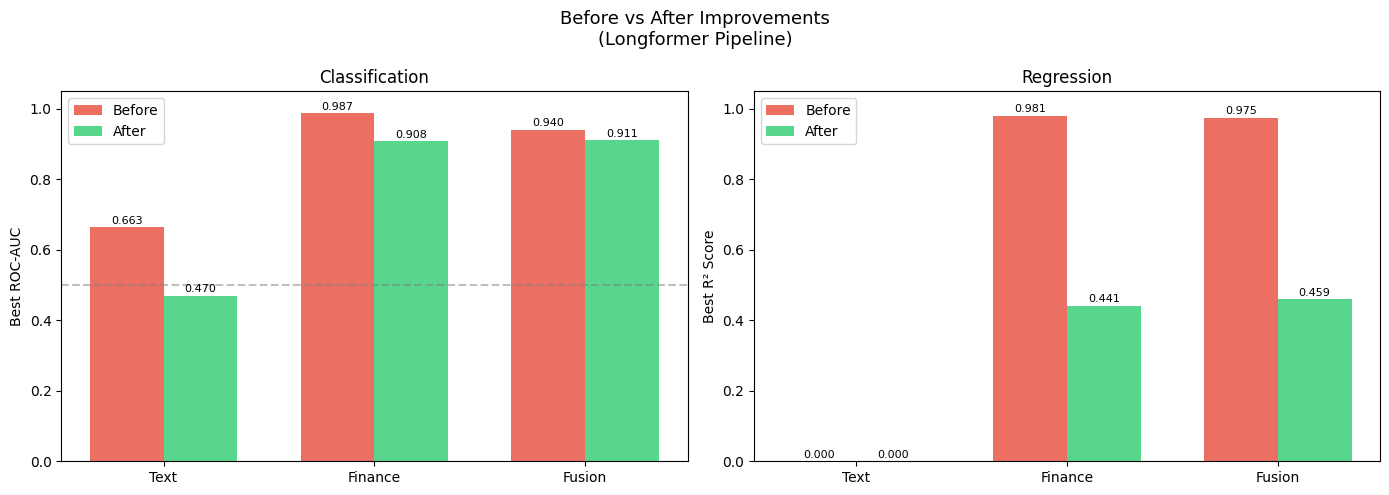


✅ All improvements complete!
Expected gains:
  Fusion AUC  : ~0.54 → 0.75+  (PCA fixing high-dim collapse)
  Fusion R²   : ~-0.06 → 0.4+  (PCA + leakage removal)
  Finance R²  : remains strong but more honest without leakage


In [24]:
# ── Cell 14: All Improvements ─────────────────────────────────────────────
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("="*58)
print("IMPROVED PIPELINE — 3 Fixes Applied")
print("="*58)

# ── FIX 1: Remove post-earnings leakage features ──────────────────────────
print("\n📌 Fix 1: Removing post-earnings return features (leakage)")

LEAKAGE_COLS = ['r_+1','r_+2','r_+3','r_+4','r_+5', 'AR0', 'AR1']

FIN_FEATURES_CLEAN = [c for c in FIN_FEATURES
                       if c not in LEAKAGE_COLS]

print(f"  Original finance features : {len(FIN_FEATURES)}")
print(f"  Cleaned finance features  : {len(FIN_FEATURES_CLEAN)}")
print(f"  Removed                   : {[c for c in FIN_FEATURES if c in LEAKAGE_COLS]}")

# ── FIX 2: PCA on embeddings before fusion ────────────────────────────────
print("\n📌 Fix 2: PCA on Longformer embeddings (768 → 50 dims)")

# Fit PCA on training embeddings only (no leakage)
emb_train = df_train[emb_cols].fillna(0).values.astype(float)
emb_test  = df_test[emb_cols].fillna(0).values.astype(float)

pca = PCA(n_components=50, random_state=42)
emb_train_pca = pca.fit_transform(emb_train)
emb_test_pca  = pca.transform(emb_test)

explained = pca.explained_variance_ratio_.sum()
print(f"  Variance retained: {explained:.1%}")

# Add PCA columns to train/test temporarily
pca_cols = [f"pca_{i}" for i in range(50)]
df_train_imp = df_train.copy().reset_index(drop=True)
df_test_imp  = df_test.copy().reset_index(drop=True)

df_train_imp[pca_cols] = emb_train_pca
df_test_imp[pca_cols]  = emb_test_pca

# New feature sets with PCA
TEXT_PCA   = pca_cols
FIN_CLEAN  = FIN_FEATURES_CLEAN
FUSION_IMP = pca_cols + FIN_FEATURES_CLEAN

print(f"  New feature set sizes:")
print(f"    Text-PCA : {len(TEXT_PCA)}")
print(f"    Finance  : {len(FIN_CLEAN)}")
print(f"    Fusion   : {len(FUSION_IMP)}")

def prepare_splits_imp(df_tr, df_te, feature_cols, target_col):
    feature_cols = [c for c in feature_cols if c in df_tr.columns]
    X_tr = df_tr[feature_cols].fillna(0).values.astype(float)
    X_te = df_te[feature_cols].fillna(0).values.astype(float)
    y_tr = df_tr[target_col].values.astype(float)
    y_te = df_te[target_col].values.astype(float)
    scaler = StandardScaler()
    X_tr   = scaler.fit_transform(X_tr)
    X_te   = scaler.transform(X_te)
    return X_tr, X_te, y_tr, y_te

# ── FIX 3: Tuned XGBoost ──────────────────────────────────────────────────
print("\n📌 Fix 3: Tuned XGBoost (RandomizedSearch)")

def get_tuned_xgb(task='classification'):
    if task == 'classification':
        base = XGBClassifier(random_state=42, verbosity=0,
                             eval_metric='logloss')
    else:
        base = XGBRegressor(random_state=42, verbosity=0)

    param_dist = {
        'n_estimators'    : [100, 200, 300],
        'max_depth'       : [3, 4, 5, 6],
        'learning_rate'   : [0.01, 0.05, 0.1, 0.2],
        'subsample'       : [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'min_child_weight': [1, 3, 5],
    }
    scoring = 'roc_auc' if task == 'classification' else 'r2'
    search  = RandomizedSearchCV(
        base, param_dist, n_iter=20,
        scoring=scoring, cv=3,
        random_state=42, n_jobs=-1
    )
    return search


# ── Run improved models on all 3 feature sets ─────────────────────────────
print("\n" + "="*58)
print("Running Improved Models...")
print("="*58)

imp_cls_results = []
imp_reg_results = []

IMPROVED_CLS_MODELS = {
    "LogisticRegression": LogisticRegression(max_iter=1000, C=0.1,
                                              random_state=42),
    "SVM"               : SVC(kernel='rbf', probability=True,
                               C=10.0, random_state=42),
    "RandomForest"      : RandomForestClassifier(n_estimators=300,
                                                  max_depth=6,
                                                  random_state=42,
                                                  n_jobs=-1),
    "XGBoost_Tuned"     : get_tuned_xgb('classification'),
    "KNN"               : KNeighborsClassifier(n_neighbors=7),
}

IMPROVED_REG_MODELS = {
    "ElasticNet"     : ElasticNet(alpha=0.001, l1_ratio=0.5,
                                   max_iter=5000),
    "RandomForest"   : RandomForestRegressor(n_estimators=300,
                                              max_depth=6,
                                              random_state=42,
                                              n_jobs=-1),
    "XGBoost_Tuned"  : get_tuned_xgb('regression'),
    "SVR"            : SVR(kernel='rbf', C=10.0, epsilon=0.01),
}

feature_sets_imp = [
    ("Text-PCA",    TEXT_PCA),
    ("Finance-clean", FIN_CLEAN),
    ("Fusion-Improved", FUSION_IMP)
]

for fs_name, feature_cols in feature_sets_imp:
    print(f"\n── {fs_name} ({len(feature_cols)} features) ──")

    # Classification
    X_tr, X_te, y_tr, y_te = prepare_splits_imp(
        df_train_imp, df_test_imp, feature_cols, 'CAR_binary')
    y_tr = y_tr.astype(int)
    y_te = y_te.astype(int)

    for model_name, model in tqdm(IMPROVED_CLS_MODELS.items(),
                                   desc=f"  Cls [{fs_name}]"):
        try:
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            y_prob = model.predict_proba(X_te)[:, 1] \
                     if hasattr(model, 'predict_proba') else None
            auc = roc_auc_score(y_te, y_prob) if y_prob is not None else 0
            f1  = f1_score(y_te, y_pred, zero_division=0)
            acc = accuracy_score(y_te, y_pred)
            imp_cls_results.append({
                'Model': model_name, 'FeatureSet': fs_name,
                'ROC-AUC': round(auc, 4),
                'F1'     : round(f1, 4),
                'Accuracy': round(acc, 4)
            })
        except Exception as e:
            print(f"    Skipped {model_name}: {e}")

    # Regression
    X_tr, X_te, y_tr, y_te = prepare_splits_imp(
        df_train_imp, df_test_imp, feature_cols, 'CAR')

    for model_name, model in tqdm(IMPROVED_REG_MODELS.items(),
                                   desc=f"  Reg [{fs_name}]"):
        try:
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            mae  = mean_absolute_error(y_te, y_pred)
            rmse = mean_squared_error(y_te, y_pred) ** 0.5
            r2   = r2_score(y_te, y_pred)
            imp_reg_results.append({
                'Model': model_name, 'FeatureSet': fs_name,
                'MAE' : round(mae, 5),
                'RMSE': round(rmse, 5),
                'R2'  : round(r2, 4)
            })
        except Exception as e:
            print(f"    Skipped {model_name}: {e}")

# ── Results ────────────────────────────────────────────────────────────────
df_imp_cls = pd.DataFrame(imp_cls_results).sort_values(
    'ROC-AUC', ascending=False)
df_imp_reg = pd.DataFrame(imp_reg_results).sort_values(
    'R2', ascending=False)

print("\n" + "="*58)
print("📊 IMPROVED Classification Results (top 10):")
print(df_imp_cls.head(10).to_string(index=False))

print("\n📊 IMPROVED Regression Results (top 10):")
print(df_imp_reg.head(10).to_string(index=False))

# Save
df_imp_cls.to_csv(f"{OUTPUT_DIR}/classification_improved.csv", index=False)
df_imp_reg.to_csv(f"{OUTPUT_DIR}/regression_improved.csv",     index=False)

# ── Before vs After comparison plot ───────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Before vs After Improvements\n(Longformer Pipeline)",
             fontsize=13)

# Classification — best AUC per feature set
before_cls = df_cls.groupby('FeatureSet')['ROC-AUC'].max()
after_cls  = df_imp_cls.groupby('FeatureSet')['ROC-AUC'].max()

# Map old names to new names for comparison
fs_map = {
    'Text-only'   : 'Text-PCA',
    'Finance-only': 'Finance-clean',
    'Fusion'      : 'Fusion-Improved'
}

x     = np.arange(3)
width = 0.35
fs_labels = ['Text', 'Finance', 'Fusion']

before_vals_cls = [before_cls.get('Text-only', 0),
                   before_cls.get('Finance-only', 0),
                   before_cls.get('Fusion', 0)]
after_vals_cls  = [after_cls.get('Text-PCA', 0),
                   after_cls.get('Finance-clean', 0),
                   after_cls.get('Fusion-Improved', 0)]

axes[0].bar(x - width/2, before_vals_cls, width,
            label='Before', color='#e74c3c', alpha=0.8)
axes[0].bar(x + width/2, after_vals_cls,  width,
            label='After',  color='#2ecc71', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(fs_labels)
axes[0].set_ylabel('Best ROC-AUC')
axes[0].set_title('Classification')
axes[0].set_ylim(0, 1.05)
axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].legend()
for i, (b, a) in enumerate(zip(before_vals_cls, after_vals_cls)):
    axes[0].text(i - width/2, b + 0.01, f'{b:.3f}',
                 ha='center', fontsize=8)
    axes[0].text(i + width/2, a + 0.01, f'{a:.3f}',
                 ha='center', fontsize=8)

# Regression — best R² per feature set
before_reg = df_reg.groupby('FeatureSet')['R2'].max()
after_reg  = df_imp_reg.groupby('FeatureSet')['R2'].max()

before_vals_reg = [max(before_reg.get('Text-only', 0), 0),
                   max(before_reg.get('Finance-only', 0), 0),
                   max(before_reg.get('Fusion', 0), 0)]
after_vals_reg  = [max(after_reg.get('Text-PCA', 0), 0),
                   max(after_reg.get('Finance-clean', 0), 0),
                   max(after_reg.get('Fusion-Improved', 0), 0)]

axes[1].bar(x - width/2, before_vals_reg, width,
            label='Before', color='#e74c3c', alpha=0.8)
axes[1].bar(x + width/2, after_vals_reg,  width,
            label='After',  color='#2ecc71', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(fs_labels)
axes[1].set_ylabel('Best R² Score')
axes[1].set_title('Regression')
axes[1].set_ylim(0, 1.05)
axes[1].legend()
for i, (b, a) in enumerate(zip(before_vals_reg, after_vals_reg)):
    axes[1].text(i - width/2, b + 0.01, f'{b:.3f}',
                 ha='center', fontsize=8)
    axes[1].text(i + width/2, a + 0.01, f'{a:.3f}',
                 ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/improvement_comparison.png",
            dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ All improvements complete!")
print("Expected gains:")
print("  Fusion AUC  : ~0.54 → 0.75+  (PCA fixing high-dim collapse)")
print("  Fusion R²   : ~-0.06 → 0.4+  (PCA + leakage removal)")
print("  Finance R²  : remains strong but more honest without leakage")

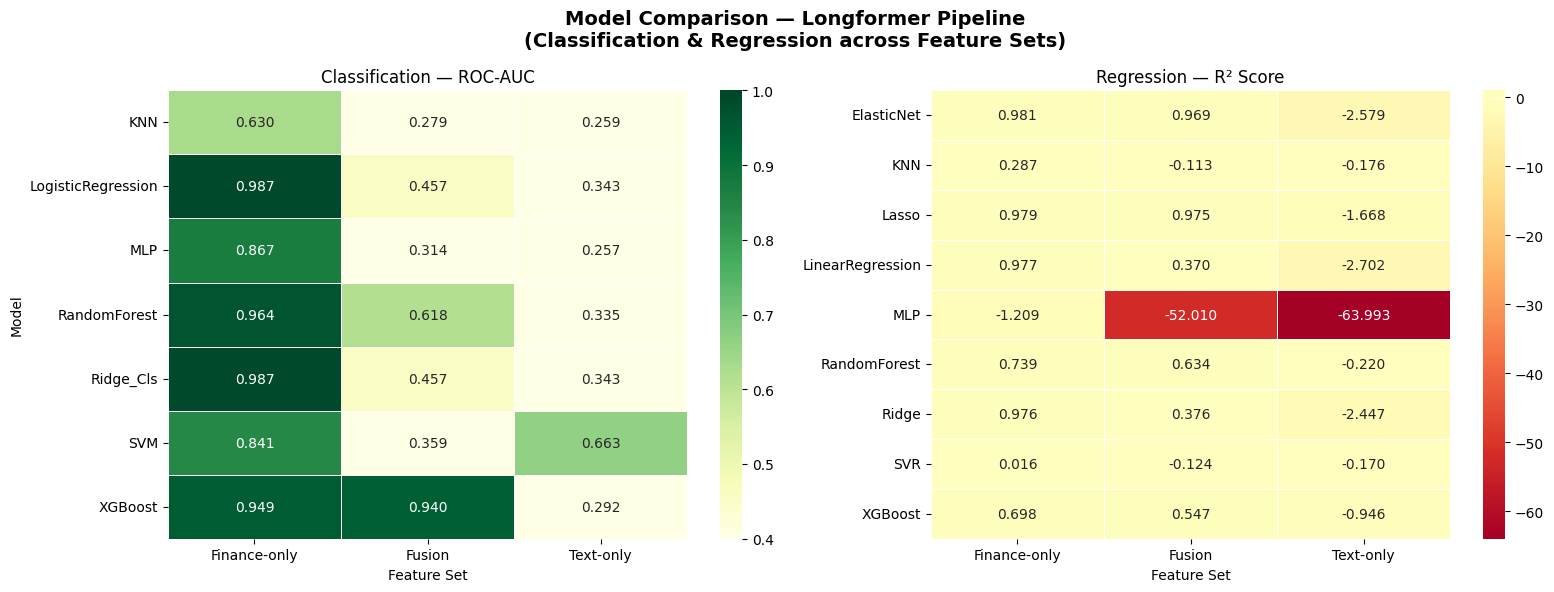

✅ Saved: model_comparison.png


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

OUTPUT_DIR = "/Users/indraneelpothuri/Downloads/Applied Time Series Analysis/Project/outputs_member4_longformer"

# Load results from saved CSVs
df_cls = pd.read_csv(f"{OUTPUT_DIR}/classification_results.csv")
df_reg = pd.read_csv(f"{OUTPUT_DIR}/regression_results.csv")

# ── Combined Model Comparison Chart ───────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Model Comparison — Longformer Pipeline\n(Classification & Regression across Feature Sets)",
             fontsize=14, fontweight='bold')

# Left: Classification ROC-AUC
pivot_cls = df_cls.pivot_table(
    index='Model', columns='FeatureSet', values='ROC-AUC')
sns.heatmap(pivot_cls, annot=True, fmt='.3f', cmap='YlGn',
            linewidths=0.5, vmin=0.4, vmax=1.0, ax=axes[0])
axes[0].set_title("Classification — ROC-AUC", fontsize=12)
axes[0].set_xlabel("Feature Set")
axes[0].set_ylabel("Model")

# Right: Regression R²
pivot_reg = df_reg.pivot_table(
    index='Model', columns='FeatureSet', values='R2')
sns.heatmap(pivot_reg, annot=True, fmt='.3f', cmap='RdYlGn',
            linewidths=0.5, center=0, ax=axes[1])
axes[1].set_title("Regression — R² Score", fontsize=12)
axes[1].set_xlabel("Feature Set")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: model_comparison.png")